In [1358]:
import torch
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
import numba as nb

from cryo_sbi.wpa_simulator.image_generation import gen_quat

In [1359]:
model_idx = 0

In [1360]:
image_params = {
    "N_PIXELS": 128,
    "PIXEL_SIZE": 2.08,
    "SIGMA": 4.0,
    "ROTATIONS": True,
    "SHIFT": False,
    "CTF": True,
    "NOISE": True,
    "DEFOCUS": 2.0,
    "SNR": 0.15,
    "RADIUS_MASK": 64,
    "AMP": 0.1,
    "B_FACTOR": 1,
    "ELECWAVE": 0.019866,
    "NOISE_INTENSITY": 0.4,
}

In [1361]:
coord = np.load("../data/protein_models/6wxb_torsion_models.npy")[model_idx]

## Rotate structure

In [1362]:
# quat = np.array([-0.76882173,  0.21902341, -0.3074588 ,  0.51615015])
quat = np.array([-0.10225028, 0.72071227, -0.62394053, -0.28428316])
# quat = gen_quat()
rot_mat = Rotation.from_quat(quat).as_matrix()
coord = np.matmul(rot_mat, coord)

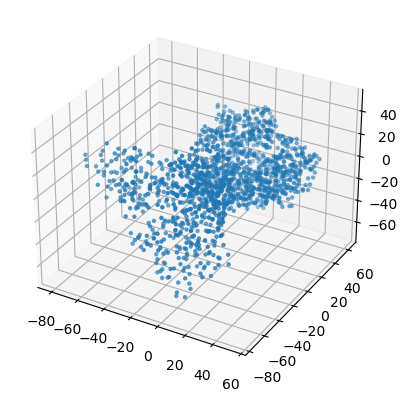

In [1363]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# ax.plot_surface(
#    x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)
xx, yy, zz = coord
im = ax.scatter(xx, yy, zz, s=5)

## Generating the projection

In [1364]:
def gen_img(coord, image_params):
    n_atoms = coord.shape[1]
    norm = 1 / (2 * torch.pi * image_params["SIGMA"] ** 2 * n_atoms)

    grid_min = -image_params["PIXEL_SIZE"] * (image_params["N_PIXELS"] - 1) * 0.5
    grid_max = (
        image_params["PIXEL_SIZE"] * (image_params["N_PIXELS"] - 1) * 0.5
        + image_params["PIXEL_SIZE"]
    )

    grid = torch.arange(grid_min, grid_max, image_params["PIXEL_SIZE"])

    gauss_x = torch.exp(
        -0.5 * (((grid[:, None] - coord[0, :]) / image_params["SIGMA"]) ** 2)
    )

    gauss_y = torch.exp(
        -0.5 * (((grid[:, None] - coord[1, :]) / image_params["SIGMA"]) ** 2)
    )

    image = torch.matmul(gauss_x, gauss_y.T) * norm

    return image

In [1365]:
def circular_mask(n_pixels, radius, x_center=None, y_center=None):
    """Creates a circular mask of radius RADIUS_MASK centered in the image.

    Args:
        n_pixels (int): Number of pixels along image side.
        radius (int): Radius of the mask.
        x_center (int): X-coordinate of the center of the circle.
        y_center (int): Y-coordinate of the center of the circle.

    Returns:
        mask (torch.Tensor): Mask of shape (n_pixels, n_pixels).
    """

    if x_center is None:
        x_center = (n_pixels - 1) / 2  # Default center
    if y_center is None:
        y_center = (n_pixels - 1) / 2  # Default center

    x = torch.linspace(0, n_pixels - 1, n_pixels)
    y = torch.linspace(0, n_pixels - 1, n_pixels)
    x_2d, y_2d = torch.meshgrid(x, y)
    r_2d = (x_2d - x_center) ** 2 + (y_2d - y_center) ** 2
    mask = r_2d < radius**2

    return mask

torch.Size([128, 128])


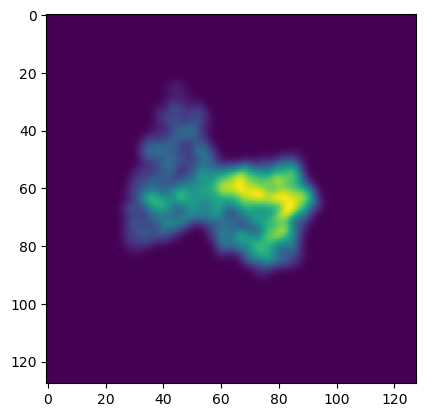

In [1366]:
image_clear = gen_img(coord, image_params)
print(image_clear.shape)
plt.imshow(image_clear)

## Add padding for shift

In [1367]:
from torch.nn import ConstantPad2d


def pad_image(image, image_params):
    pad_width = int(np.ceil(image_params["N_PIXELS"] * 0.1)) + 1

    padder = ConstantPad2d(pad_width, 0.0)

    padded_image = padder(image)

    return padded_image

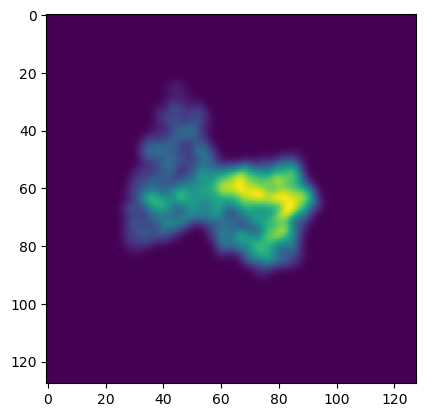

In [1368]:
# image_clear = pad_image(image_clear, image_params)
plt.imshow(image_clear)

## Calculate and add the ctf

In [1369]:
def calc_ctf(image_params):
    # Attention look into def pad_image function to know the image size after padding
    image_size = (
        # 2 * (int(np.ceil(image_params["N_PIXELS"] * 0.1)) + 1)
        image_params["N_PIXELS"]
    )
    freq_pix_1d = torch.fft.fftfreq(image_size, d=image_params["PIXEL_SIZE"])

    if isinstance(image_params["DEFOCUS"], float):
        phase = image_params["DEFOCUS"] * np.pi * 2.0 * 10000 * image_params["ELECWAVE"]

    elif (
        isinstance(image_params["DEFOCUS"], list) and len(image_params["DEFOCUS"]) == 2
    ):
        defocus = np.random.uniform(
            low=image_params["DEFOCUS"][0], high=image_params["DEFOCUS"][1]
        )
        phase = defocus * np.pi * 2.0 * 10000 * image_params["ELECWAVE"]

    else:
        raise ValueError(
            "Defocus should be a single value or a list of [min_defocus, max_defocus]"
        )

    x, y = torch.meshgrid(freq_pix_1d, freq_pix_1d)

    freq2_2d = x**2 + y**2
    imag = torch.zeros_like(freq2_2d) * 1j

    env = torch.exp(torch.tensor(-image_params["B_FACTOR"] * freq2_2d * 0.5))
    ctf = (
        -image_params["AMP"] * torch.tensor(phase * freq2_2d * 0.5).cos()
        - torch.tensor(1 - image_params["AMP"] ** 2).sqrt()
        * torch.tensor(phase * freq2_2d * 0.5).sin()
        + imag
    )
    return ctf * env / image_params["AMP"]


def circular_mask1(n_pixels, radius, inside=True):
    grid = torch.linspace(-0.5 * (n_pixels - 1), 0.5 * (n_pixels - 1), n_pixels)
    r_2d = grid[None, :] ** 2 + grid[:, None] ** 2

    if inside is True:
        mask = r_2d < radius**2
    else:
        mask = r_2d > radius**2

    return mask


def apply_ctf(image, ctf):
    conv_image_ctf = torch.fft.fft2(image) * ctf
    image_ctf = torch.fft.ifft2(conv_image_ctf).real

    return image_ctf

/tmp/ipykernel_1035844/3120727765.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  env = torch.exp(torch.tensor(-image_params["B_FACTOR"] * freq2_2d * 0.5))
/tmp/ipykernel_1035844/3120727765.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  -image_params["AMP"] * torch.tensor(phase * freq2_2d * 0.5).cos()
/tmp/ipykernel_1035844/3120727765.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.tensor(phase * freq2_2d * 0.5).sin()


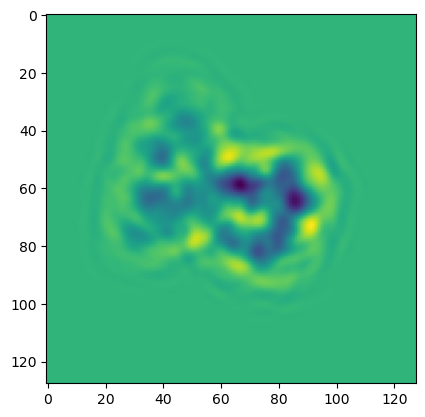

In [1370]:
ctf = calc_ctf(image_params)
image_ctf = apply_ctf(image_clear, ctf)
plt.imshow(image_ctf)

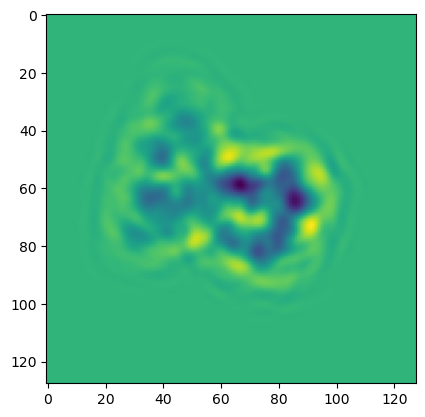

In [1371]:
plt.imshow(image_ctf)

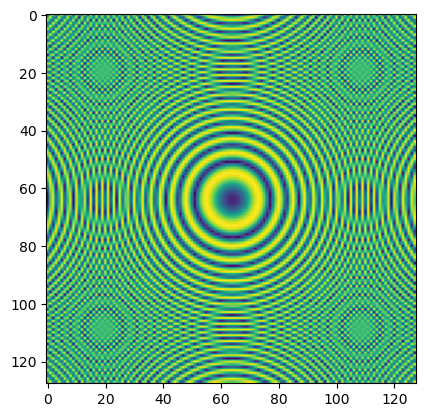

In [1372]:
plt.imshow((torch.fft.ifftshift(ctf)).abs())

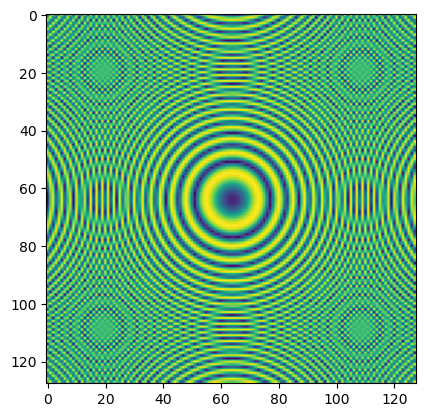

In [1373]:
plt.imshow((torch.fft.ifftshift(ctf)).abs())

## Add noise

In [1374]:
def circular_mask(n_pixels, radius):
    grid = torch.linspace(-0.5 * (n_pixels - 1), 0.5 * (n_pixels - 1), n_pixels)
    r_2d = grid[None, :] ** 2 + grid[:, None] ** 2
    mask = r_2d < radius**2

    return mask


def add_noise(img, image_params):
    mask = circular_mask(n_pixels=img.shape[0], radius=image_params["RADIUS_MASK"])

    signal_std = img[mask].pow(2).mean().sqrt()

    if isinstance(image_params["SNR"], float):
        snr = image_params["SNR"]

    elif isinstance(image_params["SNR"], list) and len(image_params["SNR"]) == 2:
        snr = np.random.uniform(low=image_params["SNR"][0], high=image_params["SNR"][1])

    else:
        raise ValueError(
            "SNR should be a single value or a list of [min_defocus, max_defocus]"
        )

    noise_std = signal_std / np.sqrt(snr)

    img_noise = img + torch.distributions.normal.Normal(0, noise_std).sample(img.shape)

    return img_noise


def add_gradient_noise(img, image_params):
    mask = circular_mask(n_pixels=img.shape[0], radius=image_params["RADIUS_MASK"])

    signal_std = img[mask].pow(2).mean().sqrt()
    noise_std = signal_std / np.sqrt(image_params["SNR"])

    noise = torch.stack(
        [
            torch.distributions.normal.Normal(0, signal_std / np.sqrt(snr)).sample(
                [
                    img.shape[0],
                ]
            )
            for snr in np.logspace(-1, -2, img.shape[0])
        ],
        dim=1,
    )

    img_noise = img + noise

    return img_noise


def add_shot_noise(clear_image, image_params):
    norm_img = clear_image.abs() / clear_image.abs().max()
    shot_noise = torch.poisson(norm_img * 0.05)

    shot_image = clear_image * (shot_noise + 1)
    print(shot_noise.sum())
    ctf_image = apply_ctf(shot_image, calc_ctf(image_params))

    img = add_noise(ctf_image, image_params)

    return img


def add_colored_noise(image, image_params, seed, noise_intensity=1, noise_scale=1.5):
    """Adds colored noise to image"""
    # Similar to pink noise https://en.wikipedia.org/wiki/Pink_noise
    if seed is not None:
        torch.manual_seed(seed)

    print(image.shape, "1")
    image_L = image.shape[0]

    mask = circular_mask(n_pixels=image.shape[0], radius=image_params["RADIUS_MASK"])

    signal_std = image[mask].pow(2).mean().sqrt()
    noise_std = signal_std / np.sqrt(image_params["SNR"])

    image_noise = torch.distributions.normal.Normal(0, noise_std).sample(image.shape)
    fft_noise = torch.fft.fft2(image_noise)

    along_x, along_y = np.linspace(-1, 1, image_L), np.linspace(-1, 1, image_L)
    mesh_x, mesh_y = np.meshgrid(along_x, along_y)
    f = torch.zeros((image_L, image_L))

    for ix in range(image_L):
        for iy in range(image_L):
            f[ix, iy] = (
                np.abs(mesh_x[ix, iy]) ** noise_scale
                + np.abs(mesh_y[ix, iy]) ** noise_scale
            )
    print(fft_noise.shape, "2")
    t = torch.abs(torch.fft.ifft2(fft_noise / f))

    # Scaling with respect to the lenght max to median
    scale = noise_intensity / (t.max() - t.median())

    # Adjusting noise so that 50% of the pixels have higer and the other 50% lower snr
    t = ((t - t.median()) * scale) + 1

    image_noise = torch.distributions.normal.Normal(0, noise_std * t).sample()
    return image_noise + image

In [1375]:
def gen_noise_field(image_params: dict, num_sin_func: int = 50) -> torch.Tensor:
    """
    Generate a noise field with a given number of sinusoidal functions.

    Args:
        num_pixels (int): Number of pixels in the noise field.
        num_sin_func (int, optional): Number of sinusoidal functions. Defaults to 10.
        max_intensity (float, optional): Maximum intensity of the noise field. Defaults to 1e-3.

    Returns:
        torch.Tensor: Noise field.
    """

    x = torch.linspace(
        0,
        image_params["N_PIXELS"] * image_params["PIXEL_SIZE"],
        image_params["N_PIXELS"],
    )
    y = torch.linspace(
        0,
        image_params["N_PIXELS"] * image_params["PIXEL_SIZE"],
        image_params["N_PIXELS"],
    )

    max_freq = np.pi / (image_params["PIXEL_SIZE"])
    min_freq = 2 * np.pi / (image_params["N_PIXELS"] * image_params["PIXEL_SIZE"])
    exp_coeff = (max_freq - min_freq) / 20
    xx, yy = torch.meshgrid(x, y, indexing="ij")

    a = 1 * torch.rand(num_sin_func, 1)
    b = 0.15 * torch.randn(
        (num_sin_func, 2)
    )  # torch.from_numpy(np.random.exponential(exp_coeff, size=(num_sin_func, 2))) + min_freq
    c = 2 * torch.pi * (torch.rand(num_sin_func, 1))

    noise_field = torch.zeros_like(xx, dtype=torch.double)
    for i in range(num_sin_func):
        noise_field += a[i] * torch.sin(b[i, 0] * xx + b[i, 1] * yy + c[i, 0])

    return noise_field

In [1376]:
# %timeit gen_noise_field(image_params, 200)

In [1377]:
# from cryo_sbi.wpa_simulator.implicit_water import gen_noise_field

In [1378]:
# %timeit gen_noise_field(image_params, 200)

In [1379]:
# image = add_colored_noise(image_ctf, image_params, seed=None, noise_intensity=1, noise_scale=1.5)

In [1380]:
# image = add_shot_noise(image, image_params)

In [1381]:
# plt.imshow(add_colored_noise(image, image_params))

In [1382]:
# add_shot_noise(image, image_params).max()

In [1383]:
from cryo_sbi.wpa_simulator.noise import correlated_gaussian_noise
from cryo_sbi.wpa_simulator.implicit_water import gen_noise_field, generate_noise_field

In [1384]:
image = correlated_gaussian_noise(image_ctf, image_params)

In [1385]:
# plt.imshow(add_shot_noise(image_clear, image_params))

## Add random shift

In [1386]:
def apply_random_shift(padded_image, image_params):
    shift_x = int(torch.ceil(image_params["N_PIXELS"] * 0.1 * (2 * torch.rand(1) - 1)))
    shift_y = int(torch.ceil(image_params["N_PIXELS"] * 0.1 * (2 * torch.rand(1) - 1)))

    pad_width = int(np.ceil(image_params["N_PIXELS"] * 0.1)) + 1

    low_ind_x = pad_width - shift_x
    high_ind_x = padded_image.shape[0] - pad_width - shift_x

    low_ind_y = pad_width - shift_y
    high_ind_y = padded_image.shape[0] - pad_width - shift_y

    shifted_image = padded_image[low_ind_x:high_ind_x, low_ind_y:high_ind_y]

    return shifted_image


def apply_no_shift(padded_image, image_params):
    pad_width = int(np.ceil(image_params["N_PIXELS"] * 0.1)) + 1

    low_ind_x = pad_width
    high_ind_x = padded_image.shape[0] - pad_width

    low_ind_y = pad_width
    high_ind_y = padded_image.shape[0] - pad_width

    shifted_image = padded_image[low_ind_x:high_ind_x, low_ind_y:high_ind_y]

    return shifted_image

In [1387]:
# image = apply_no_shift(image, image_params)
# plt.imshow(image)

## Normalize image

In [1388]:
def gaussian_normalize_image(image):
    mean_img = torch.mean(image)
    std_img = torch.std(image)

    return (image - mean_img) / std_img


image = gaussian_normalize_image(image).to(dtype=torch.float)

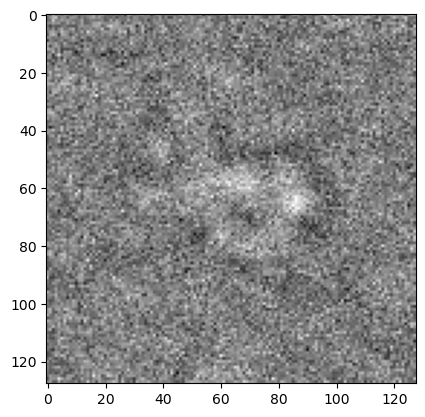

In [1389]:
plt.imshow(image, vmax=4, vmin=-4, cmap="binary")

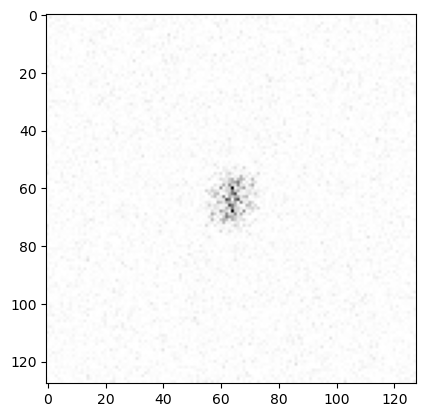

In [1390]:
plt.imshow(torch.abs(torch.fft.fftshift(torch.fft.fft2(image)) ** 2), cmap="binary")